# SCE NLP Workshop Solution

This is the solution to the NLP workshop. It's written to be run on Kaggle for the [NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) contest. You should write your own version, starting with the `nlp_workshop.ipynb` notebook.

In [1]:
!pip install Unidecode -q
!pip install numpy -q
!pip install pandas -q
!pip install tqdm -q
!pip install matplotlib -q
!pip install torch -q
!pip install -U tensorflow -q
!pip install transformers -q

from unidecode import unidecode # remove accents from characters
import html    # for html encoded characters (e.g. &amp;)
import re      # regular expressions

import numpy as np        # linear algebra
import pandas as pd       # data processing
from tqdm import tqdm     # progress bars
import matplotlib.pyplot as plt  # plot graphs
import seaborn as sns

# Scikit-learn machine learning library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# deep learning library; our BERT model from Hugging Face uses PyTorch
import torch

# deep learning library, like PyTorch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from transformers import AutoTokenizer, AutoModel # Hugging Face NLP

# use cuda with PyTorch if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'using {torch.cuda.get_device_name(0)}\n')
else:
    print('no GPU avaiable\n')

# TensorFlow automatically uses cuda
print(device_lib.list_local_devices(), end='\n\n')

np.random.RandomState(123) # seed RNG for reproducibility

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## data exploration

Load the training data and checkout what we're working with.

In [2]:
# load training data
df_ori = pd.read_csv('https://raw.githubusercontent.com/SCE-Development/Courses/master/NLP/input/train.csv')

df_ori # data frame original: contains unmodified training data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Look at samples from the training data

In [3]:
# look at 10 keywords
df_ori['keyword'].unique()[:10]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon'], dtype=object)

In [4]:
# look at 10 locations
df_ori['location'].unique()[:10]

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam'], dtype=object)

In [5]:
# look at 10 posts
for index, text in df_ori['text'].iteritems():
    # repr() will print special characters as escaped
    # e.g. '\n' for newline
    print(repr(text), end='\n\n')
    if index == 10:
        break

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'Forest fire near La Ronge Sask. Canada'

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

'13,000 people receive #wildfires evacuation orders in California '

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

"I'm on top of the hill and I can see a fire in the woods..."

"There's an emergency evacuation happening now in the building across the street"

"I'm afraid that the tornado is coming to our area..."

'Three people died from the heat wave so far'



We're going to ignore 'id' and 'location' because they're useless. 'keyword' might be helpful, but we'll ignore that too.

In [6]:
# drop columns (axis=1)
df = df_ori.drop(labels=['id', 'keyword', 'location'], axis=1)

df.shape # returns the dimensions of the data frame

(7613, 2)

## BERT

BERT is a transformer, which maps a sentence into a sentence embedding (i think?). You can think of it as transforming sentences into vectors that represent the sentence.

We're going to use a pretrained model from [Hugging Face](https://huggingface.co/transformers/model_doc/distilbert.html) called DistilBERT. It's been shown to be faster than BERT with similar performance.

### preprocessing

BERT doesn't require much preprocessing. We just need to do the following:

1. lowercase
2. handle special characters (e.g. ü)
3. remove punctuation (we're considering each tweet as one sentence)

In [9]:
def clean(text: str) -> str:
    '''Normalize a text sample'''
    
    # unescape html
    text = html.unescape(text)
    
    # remove mentions
    text = re.sub(r'(^|.)@[^\s]*', r'', text)
    
    # remove urls
    text = re.sub(r'https?:\/\/[^\s]*', r'', text)
    
    # remove accented characters
    text = unidecode(text)
    
    # remove unwanted characters
    text = re.sub(r"[^a-zA-Z\s']+", r' ', text)
    
    # remove repeated apostrophes
    text = re.sub(r"(['])[']+", r'\1', text)
    
    # remove whitespace from the sides
    text = text.strip()
    
    # turn whitespace into a space
    text = re.sub(r'\s+', r' ', text)
    
    # lowercase
    text = text.lower()
    
    return text

In [10]:
# clean all our text
df['text'] = df['text'].apply(clean)
df['text'].iat[0]

'our deeds are the reason of this earthquake may allah forgive us all'

### encode

1. Tokenize words into IDs in BERT's vocabulary
2. Add `[CLS]` tokens to classify the text
3. Add `[SEP]` tokens at the ends of sentences (BERT needs them surrounding each sentence)
4. Pad tokens to the same length
5. Create an attention mask to ignore padding

If our samples were too long (> 512 tokens), we would have to truncate them or create a list of sentences. Luckily, tweets are quite short.

In [11]:
# download a pretrained tokenizer (needs internet)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Hugging Face has a BertNormalizer class that can do some of what our `clean()` function does

```py
from tokenizers.normalizers import BertNormalizer

tokenizer.normalizer = BertNormalizer(
    clean_text=True, handle_chinese_chars=True,
    strip_accents=True, lowercase=True
)
```

In [12]:
def encode_text(text: list):
    '''Encodes text
    
    Arguments:
        text (list): Array of strings.
        
    Returns:
        np.ndarray: 3D array of encodings; (sample, [tokens, mask], value)
    '''
    
    encodings = tokenizer(
        text,
        add_special_tokens=True, padding=True, truncation=True,
        return_attention_mask=True, return_tensors='np'
    )

    encodings = np.stack(
        [encodings.input_ids, encodings.attention_mask], axis=1)
    
    return encodings

In [13]:
# encode all our text
encodings = encode_text(df['text'].to_list())
encodings.shape

(7613, 2, 43)

Tokens are encoded IDs for words in BERT's vocabulary.

Example from [Jay Alammar](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/#how-a-single-prediction-is-calculated)

Input sentence  
`a visually stunning rumination on love`

Break words into tokens in BERT's vocabulary  
`a` `visually` `stunning` `rum` `##ination` `on` `love`

Add special tokens  
`[CLS]` `a` `visually` `stunning` `rum` `##ination` `on` `love` `[SEP]`

Encode tokens into IDs  
`101` `1037` `17453` `14726` `19379` `12758` `2006` `2293` `102`

In [14]:
#  tokens
encodings[0][0]

array([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,
        2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

The attention mask tells BERT which tokens are real (ones) and which are padded (zeros)

In [15]:
# attention mask
encodings[0][1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### embed

Use BERT to transform the text into embeddings (vectors of numbers to represent the sentence).

In [16]:
# download a pretrained model (needs internet)
bert_model = AutoModel.from_pretrained('distilbert-base-uncased')

Get class embeddings. Each chunk from a sample gets a vector of 768 embeddings (from the 768 hidden layers).

Source: [Jay Alammar](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/#processing-with-distilbert)

In [17]:
def embed_encodings(encodings):
    '''Transfrom encoded samples.
    
    Arguments:
        encodings (np.ndarray): 3D array of encodings;
            (sample, [tokens, mask], value)
    
    Returns:
        numpy.ndarray: 2D array of 768 hidden states for the '[CLS]' token
            for each sample; (sample, embeddings)
    '''

    X = []

    for sample in tqdm(encodings):
        tokens = torch.tensor(sample[0])
        mask = torch.tensor(sample[1])

        with torch.no_grad():
            last_hidden_states = bert_model(tokens.unsqueeze(0), attention_mask=mask)

        # we only care about class embeddings
        embeddings = last_hidden_states[0][:,0,:][0].numpy()

        X.append(embeddings)

    X = np.stack(X, axis=0)

    return X

This step takes a while, so we'll reduce the size of our training data. Once everything is working, switch to using a GPU transform all the data.

In [18]:
# reduced data size for convenience
encodings = encodings[:500]

# match input samples
y = df[df.index < 500]
y = y['target'].to_numpy()

X = embed_encodings(encodings)

print(X.shape, y.shape)

100%|██████████| 500/500 [00:46<00:00, 10.74it/s]

(500, 768) (500,)


## split train and test data

We need to split our training data into training and validation data. We use training data to train our model, then validation data to check our performance (and tweak our model if necessary).

In [20]:
X_train, X_val, y_train, y_val = map(
    lambda x: np.stack(x, axis=0),
    train_test_split(X, y, random_state=123, stratify=y)
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(375, 768) (125, 768) (375,) (125,)


## ANN

We'll use an artifical neural network on the sentence embeddings to perform classification.

In [22]:
def build_ann(input_shape: tuple):
    '''Builds an artifical neural network.'''
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        
        tf.keras.layers.Dense(64, activation='relu', name='hidden_1'),
        tf.keras.layers.Dropout(0.2, name='dropout_1'), # regularization
        
        tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
# build our model
ann_model = build_ann(X_train.shape[1])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 64)                49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 65        
Total params: 49,281
Trainable params: 49,281
Non-trainable params: 0
_________________________________________________________________


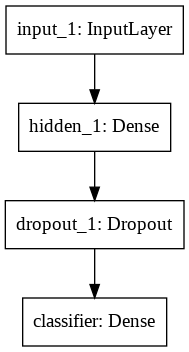

In [24]:
# show the model as a flowchart
tf.keras.utils.plot_model(ann_model)

### training

In [25]:
# prevent overfitting
es_callback = EarlyStopping(monitor='val_loss', patience=3)

Epoch 1/30
9/9 [==============================] - 1s 69ms/step - loss: 0.6279 - accuracy: 0.6749 - val_loss: 0.4470 - val_accuracy: 0.8404
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 0.4864 - accuracy: 0.7616 - val_loss: 0.3713 - val_accuracy: 0.8723
Epoch 3/30
9/9 [==============================] - 0s 8ms/step - loss: 0.4614 - accuracy: 0.7714 - val_loss: 0.3507 - val_accuracy: 0.8723
Epoch 4/30
9/9 [==============================] - 0s 8ms/step - loss: 0.4156 - accuracy: 0.7884 - val_loss: 0.3386 - val_accuracy: 0.8617
Epoch 5/30
9/9 [==============================] - 0s 8ms/step - loss: 0.3589 - accuracy: 0.8129 - val_loss: 0.3347 - val_accuracy: 0.8723
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 0.3843 - accuracy: 0.8279 - val_loss: 0.3419 - val_accuracy: 0.8617
Epoch 7/30
9/9 [==============================] - 0s 10ms/step - loss: 0.3542 - accuracy: 0.8429 - val_loss: 0.3401 - val_accuracy: 0.8723
Epoch 8/30
9/9 [================

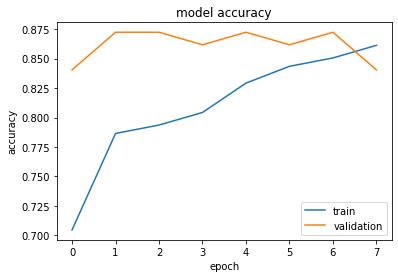

In [26]:
history = ann_model.fit(
    X_train, y_train, epochs=30, validation_split=0.25,
    callbacks=[es_callback], shuffle=False
    )

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### validation

In [28]:
ann_model.evaluate(X_val, y_val)

4/4 [==============================] - 0s 3ms/step - loss: 0.3080 - accuracy: 0.8560


[0.30801212787628174, 0.8560000061988831]

When we make predictions, our model outputs logits. These are values continuous probabilities between 0 and 1 that indicate which class our model thinks is the correct label. We can snap the probabilites to discrete binary values to get the predicted label.

In [29]:
@tf.function
def logits2labels(l):
    '''Converts a (1,) tensor of logits into a binary label.

    Arguments:
        l (tf.Tensor): A (1,) tensor of logits.

    Returns:
        int: The logit rounded to 0 or 1.
    '''

    if tf.greater(l[0], 0.5):
        return 1
    return 0

In [30]:
def make_predictions(model, X):
    '''Makes predictions on a dataset using a model.

    Arguments:
        model (tf.keras.Model): The model to use.
        X (np.ndarray): A 2D array of samples: (sample, 768)

    Returns:
        np.ndarray: A 1D array of predictions: (prediction,)
    '''

    logits = model.predict(X)
    pred = np.apply_along_axis(logits2labels, 1, logits)

    return pred

In [31]:
y_pred = make_predictions(ann_model, X_val)
y_pred.shape

(125,)

A confusion matrix can help visualize what our model is predicting. We don't want outliers which would suggest biases (or labels that are similar).

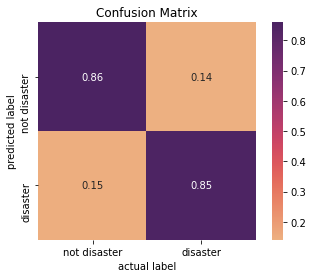

In [32]:
confusion_mat = np.zeros((2, 2))

for pred, act in zip(y_pred, y_val):
    confusion_mat[pred][act] += 1

confusion_mat = normalize(confusion_mat, axis=1, norm='l1')

sns.heatmap(
    confusion_mat,
    cmap='flare',
    square=True,
    annot=True,
    xticklabels=['not disaster','disaster'],
    yticklabels=['not disaster','disaster']
)
plt.title('Confusion Matrix')
plt.xlabel('actual label')
plt.ylabel('predicted label') 

plt.show()

## Submission

This will take a while.

1. Clean training data set
2. Use BERT to embed text
3. Build ANN
4. Train on all samples
5. Predict labels on the test data set

In [ ]:
def preprocess_pipeline(df):
    '''Clean and Encode a data set.
    
    Arguments:
        df (pandas.DataFrame): The data set, with samples in the 'text' column.
        
    Returns:
        np.ndarray: 3D array of encodings; (index, [tokens, mask], value)
    '''
    
    # clean text
    text = df['text'].apply(clean).to_list()

    # encode text
    encodings = encode_text(text)

    return encodings

In [ ]:
df = df_ori.drop(labels=['id', 'keyword', 'location'], axis=1)

y = df['target'].to_numpy()

X = preprocess_pipeline(df)

print(X.shape, y.shape)

In [ ]:
# embed text
X = embed_encodings(X)
X.shape

In [ ]:
# build ANN
ann_model = build_ann(X.shape[1])

ann_model.summary()

In [ ]:
ann_model.fit(
    X, y, epochs=30, validation_split=0.25,
    callbacks=[es_callback], shuffle=False
)

Time to predict disaster tweets!

In [ ]:
# load test set
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_test = df_test.drop(labels=['keyword', 'location'], axis=1)

X_test = preprocess_pipeline(df_test)
X_test.shape

In [ ]:
X_test = embed_encodings(X_test)
X_test.shape

In [ ]:
df_test['target'] = make_predictions(ann_model, X_test)
df_test.head()

Save your predictions to a CSV file. We only want the `id` and `target` columns. Then go back to Kaggle and submit!

In [ ]:
df_test = df_test.drop(labels=['text', 'keyword', 'location'], axis=1)
df_test.to_csv('submission.csv', index=False)